## Task 4.3: Supervised ML - Regression and Hyperparameter tuning

**Author**: Andre Schomakers

**Date**: 09 Mar 2025

This interactive Python notebook `.ipynb` is used for supervised ML for task 4.3 regression and hyperparameter tuning.



In [1]:
# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


### Initial preprocessing


In [2]:
# load the dataset via pandas
df = pd.read_csv("BloodBrain.csv")

In [3]:
df # (208x135)

,tpsa,nbasic,negative,vsa_hyd,a_aro,weight,peoe_vsa.0,peoe_vsa.1,peoe_vsa.2,peoe_vsa.3,...,ctdh,ctaa,mchg,achg,rdta,n_sp2,n_sp3,o_sp2,o_sp3,logBBB
0,12.030000,1,0,167.06700,0,156.293,76.94749,43.44619,0.00000,0.000000,...,1,1,0.9241,0.9241,1.0000,0.000000,6.0255,0.000000,0.000000,1.08
1,49.330002,0,0,92.64243,6,151.165,38.24339,25.52006,0.00000,8.619013,...,2,2,1.2685,1.0420,1.0000,0.000000,6.5681,32.010201,33.613499,-0.40
2,50.529999,1,0,295.16700,15,366.485,58.05473,124.74020,21.65084,8.619013,...,1,4,1.2562,1.2562,0.2500,26.973301,10.8567,0.000000,27.545099,0.22
3,37.389999,0,0,319.11220,15,382.552,62.23933,124.74020,13.19232,21.785640,...,1,3,1.1962,1.1962,0.3333,21.706499,11.0017,0.000000,15.131600,0.14
4,37.389999,1,0,299.65800,12,326.464,74.80064,118.04060,33.00190,0.000000,...,1,3,1.2934,1.2934,0.3333,24.206100,10.8109,0.000000,15.133300,0.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,32.700001,1,0,233.69200,6,250.362,51.28292,109.50990,13.19232,0.000000,...,1,3,0.8717,0.8717,0.3333,0.000000,3.1150,0.000000,49.692799,-0.02
204,3.240000,0,0,343.24290,10,292.446,40.59702,104.67720,13.19232,0.000000,...,0,1,0.0000,0.0000,0.0000,0.000000,4.6658,0.000000,0.000000,0.08
205,32.340000,1,0,234.79200,6,261.389,75.11627,86.66676,0.00000,8.619013,...,1,2,1.2276,1.2276,0.5000,0.000000,16.1765,54.358601,0.000000,0.25
206,37.299999,0,0,124.25940,0,143.206,63.98079,14.70850,0.00000,0.000000,...,1,2,0.9082,0.9082,0.5000,0.000000,0.0000,30.101400,15.944600,-0.84


In [4]:
# checking for missing values
df.isna().sum().sum() # no obvious missing values

np.int64(0)

### Preparing for RandomForest

Initially, the dataset needs to be understood. When visiting the `caret` homepage ([see here](https://topepo.github.io/caret/data-sets.html)),
following instruction can be found:

" ...  to predict the log of the ratio of the concentration of a compound in the brain and the concentration in blood"

we can conclude from this statement that `logBBB` is our continous target variable $y$. 

Scaling/Centering is **not** performed, as the RandomForest Regressor is a tree-partitioning algorithm which is independent on the units and scales of the input features [see Stackoverflow, accessed 09.05.25](https://stats.stackexchange.com/questions/255765/does-random-forest-need-input-variables-to-be-scaled-or-centered).

In [5]:
df['logBBB'].describe() # lays on an interval between [-2.15, 1.64]

count    208.000000
mean      -0.018894
std        0.779321
min       -2.150000
25%       -0.422500
50%        0.020000
75%        0.530000
max        1.640000
Name: logBBB, dtype: float64

In [6]:
X = df.drop('logBBB', axis=1)
y = df['logBBB']

In [7]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

In [22]:
# due to compute power, a "smaller" parameter grid for grid search is setted up:
# valus are also on the lower side to avoid overfitting. The more trees and the greater the depth, to more likely the rf will overfitt

param_grid = {
    'n_estimators': [25, 50, 100, 200],       # number of trees in the forest
    'max_depth': [None, 5, 10, 15],          # max depth of each tree
    'min_samples_split': [2, 3, 5],        # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 3, 5]          # Minimum number of samples required to be at a leaf node
}

In [23]:
# init the rf
rf_regressor = RandomForestRegressor(random_state=42)

In [24]:
# init GridSearchCV
# a negative MSE is used as GridSearchCV tries to maximize the score,
# so a lower MSE (better) means a higher negative MSE.
grid_search = GridSearchCV(estimator=rf_regressor,
                           param_grid=param_grid,
                           cv=10,  # 10-fold cross-val
                           scoring='neg_mean_squared_error',
                           n_jobs=-1, # Use all available cores
                           verbose=1)

In [ ]:
# fitting GridSearchCV to the training data (60s runtime)
print("Starting GridSearchCV...")
grid_search.fit(X_train, y_train)
print("GridSearchCV complete.")

Starting GridSearchCV...
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
GridSearchCV complete.


### Model evaluation based on the cross-validation results

In [26]:
print("\nBest Hyperparameters found by GridSearchCV:")
print(grid_search.best_params_)

best_cv_mse = -grid_search.best_score_
best_cv_rmse = np.sqrt(best_cv_mse)
print(f"\nBest Cross-Validated MSE: {best_cv_mse:.4f}")
print(f"Best Cross-Validated RMSE: {best_cv_rmse:.4f}")


Best Hyperparameters found by GridSearchCV:
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}

Best Cross-Validated MSE: 0.2847
Best Cross-Validated RMSE: 0.5336


In [27]:
# extract the best model
best_rf_model = grid_search.best_estimator_

# feature importances (useful as the number of features is pretty high)
importances = best_rf_model.feature_importances_
feature_names = X.columns # original feature names

# df for feature importances
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance_df.head(10))


Top 10 Feature Importances:
                  feature  importance
93                  fnsa3    0.205537
71                   tcnp    0.121989
76   most_positive_charge    0.049899
60                    prx    0.037412
29             slogp_vsa0    0.029227
14           peoe_vsa.1.1    0.021676
130                 n_sp2    0.021385
66             polar_area    0.020876
68               psa_npsa    0.020263
48              logp.o.w.    0.019700


/tmp/ipykernel_78883/69765447.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(top_n), palette='viridis')


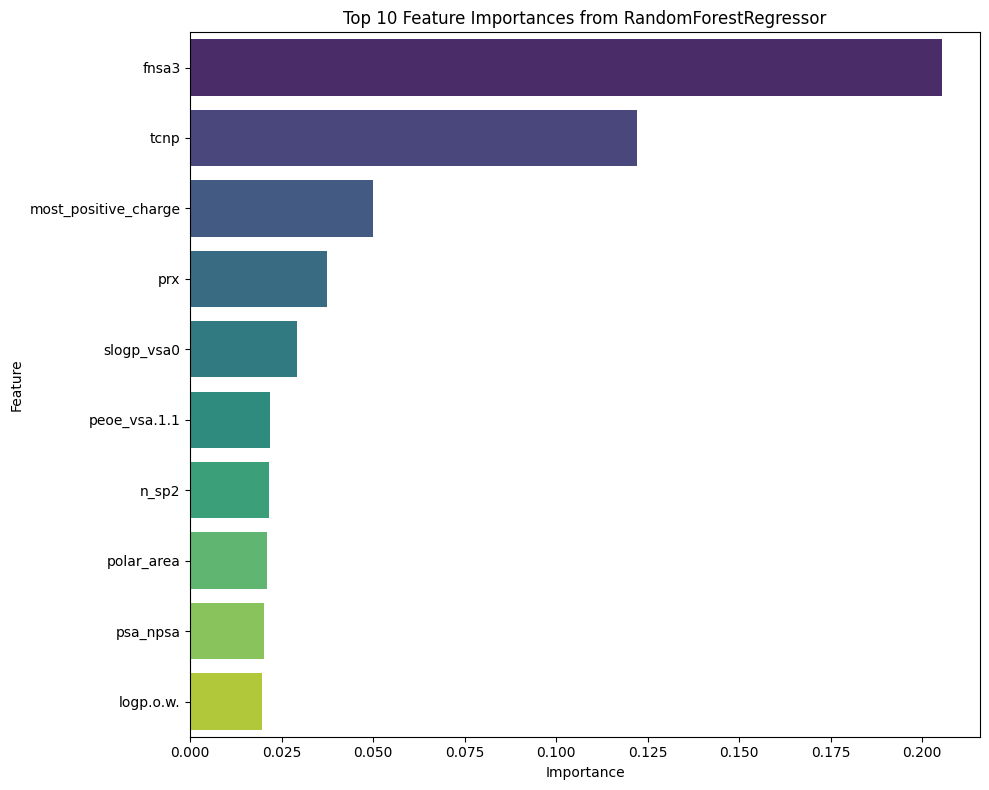

In [28]:
# plotting feature importances
plt.figure(figsize=(10, 8))
top_n = 10
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Feature Importances from RandomForestRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Prediction using the best RF-regressor estimator

In [29]:
y_pred_test = best_rf_model.predict(X_test)

In [30]:
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred_test)

print("\nPerformance on the Test Set:")
print(f"Mean Squared Error (MSE): {test_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.4f}")
print(f"R-squared (R2 Score): {test_r2:.4f}")


Performance on the Test Set:
Mean Squared Error (MSE): 0.2402
Root Mean Squared Error (RMSE): 0.4901
R-squared (R2 Score): 0.4255


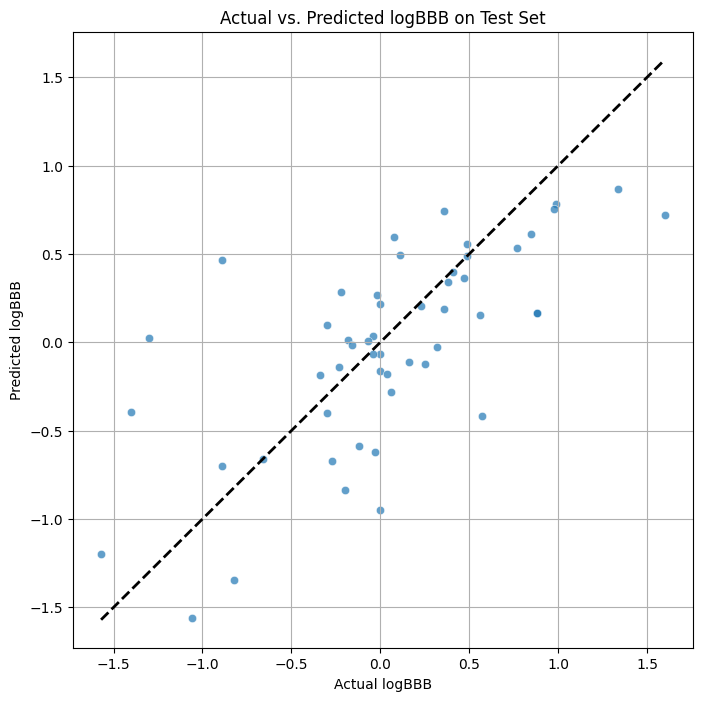

In [33]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_test, alpha=0.7, edgecolors='w', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) # Diagonal line
plt.xlabel('Actual logBBB')
plt.ylabel('Predicted logBBB')
plt.title('Actual vs. Predicted logBBB on Test Set')
plt.grid(True)
plt.show()

### Building a smaller model based on the most important features

In [ ]:
top_n = 5
selected_feature_names = feature_importance_df['feature'].head(top_n).tolist()

print(f"\nTop {top_n} selected feature names based on importance:")
print(selected_feature_names)


Top 5 selected feature names based on importance:
['fnsa3', 'tcnp', 'most_positive_charge', 'prx', 'slogp_vsa0']


In [43]:

X_train_selected = X_train[selected_feature_names]
X_test_selected = X_test[selected_feature_names]

In [44]:
# re-running with only the most 5 important features and evaluate on R²
# using the same param grid as above

rf_regressor_selected = RandomForestRegressor(random_state=42)
grid_search_selected = GridSearchCV(estimator=rf_regressor_selected,
                    param_grid=param_grid,
                    cv=10,
                    scoring='r2',
                    n_jobs=-1,
                    verbose=1)

In [45]:
print("\nStarting GridSearchCV with selected unscaled features...")
grid_search_selected.fit(X_train_selected, y_train) # y-train remains the same of course
print("GridSearchCV with selected unscaled features complete.")

best_rf_model_selected = grid_search_selected.best_estimator_


Starting GridSearchCV with selected unscaled features...
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
GridSearchCV with selected unscaled features complete.


In [ ]:
print(grid_search_selected.best_params_)
print(f"Best CV R2 Score (selected unscaled features): {grid_search_selected.best_score_:.4f}")

# predict
y_pred_test_selected = best_rf_model_selected.predict(X_test_selected)

# based on the 5 most important features from the full model, the shrinked model has a worse R² score ...
test_r2_selected = r2_score(y_test, y_pred_test_selected)
print(f"R-squared (R2 Score): {test_r2_selected:.4f}")


{'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}
Best CV R2 Score (selected unscaled features): 0.4780
R-squared (R2 Score): 0.2043


**Final thoughts**

Based on the results, the full model with all features included is yielding an R² of 0.42 on the test set. Given the intervall of $[0,1]$ of R², this is not really a satisfying result. Additionally, compared to the Actual vs Predicted scatter plot we can see that the residuals spread to a certain degree yielding this mediocre R². Given the metrics, another model was created using the 5 most important features from the base model which yielded even a smaller/worse R² of 0.2 on the test set (usign the same paramter grid with `GridSearchCV`).

In order to use the full potential of hyperparameter tuning I would say that also domain knowledge comes into place. I have no idea about biological data and didnt check the paper (due to time contraints). If potential outliers or specific features could be discarded from the initial feature space the results would have yielded a far better performance. In addition to that I'd argue that `GridSearchCV` is maybe not the best method as the parameter space in this case is completely unknown. I would have used `RandomSearchCV` instead.

In conclusion, one can say, that even with "automating" the search for best params for an estimator to learn patterns, it is still very hard to find the sweet spot of a non-overfitting model with a solid performance.